In [27]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jaxopt import OptaxSolver
import relaxed
from celluloid import Camera
from functools import partial
import matplotlib.lines as mlines

# matplotlib settings
plt.rc("figure", figsize=(6, 2), dpi=150, facecolor="w")

# Optimising a simple one-bin analysis with a systematic using `relaxed`

Let's define an analysis with a predicted number of signal and background events, with some uncertainty on the background estimate. We'll abstract the analysis configuration into a single parameter $\phi$ like so:

$$s = 15 + \phi $$
$$b = 45 - 2 \phi $$
$$\sigma_b = 0.5 + 0.1*\phi^2 $$

Note that $s \propto \phi$ and $\propto -2\phi$, so increasing $\phi$ corresponds to increasing the signal/backround ratio. However, our uncertainty scales like $\phi^2$, so we're also going to compromise in our certainty of the background count as we do that. This kind of tradeoff between $s/b$ ratio and uncertainty is important for the discovery of a new signal, so we can't get away with optimising $s/b$ alone.

To illustrate this, we'll plot the discovery significance for this model with and without uncertainty.

In [28]:
# model definition
def yields(phi, uncertainty=True):
    s = 15 + phi
    b = 45 - 2 * phi
    db = (
        0.5 + 0.1 * phi**2 if uncertainty else jnp.zeros_like(phi) + 0.001
    )  # small enough to be negligible
    return jnp.asarray([s]), jnp.asarray([b]), jnp.asarray([db])

In [29]:
# just plotting code
def yield_plot(phi):
    s, b, db = yields(phi)
    s, b, db = s.ravel(), b.ravel(), db.ravel()  # everything is [[x]] for pyhf
    fig, ax = plt.subplots(figsize=[2, 2])
    ax.set_ylim((0, 80))
    b1 = ax.bar(0.5, b, facecolor="C1", label="b")
    b2 = ax.bar(0.5, s, bottom=b, facecolor="C9", label="s")
    b3 = ax.bar(
        0.5, db, bottom=b - db / 2, facecolor="k", alpha=0.5, label=r"$\sigma_b$"
    )
    ax.set_xlabel("single bin")
    ax.set_ylabel("yield")
    ax.set_xticks([])
    ax.legend(
        [b1, b2, b3],
        ["b", "s", r"$\sigma_b$"],
        frameon=False,
        bbox_to_anchor=(1.04, 0.5),
        loc="center left",
        borderaxespad=0,
    )


import ipywidgets as widgets

slider = widgets.FloatSlider(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description=r"$\varphi$:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
)
widgets.interactive(yield_plot, phi=slider)

interactive(children=(FloatSlider(value=7.5, description='$\\varphi$:', max=10.0, readout_format='.1f'), Outpu…

## Implementing the discovery $p$-value using `relaxed`

In [ ]:
# our analysis pipeline, from phi to p-value
def pipeline(phi, return_yields=False, uncertainty=True):

    # grab the yields at the value of phi we want
    y = yields(phi, uncertainty=uncertainty)

    # use a dummy version of pyhf for simplicity + compatibility with jax
    model = relaxed.dummy_pyhf.uncorrelated_background(*y)

    # calculate expected discovery significance
    nominal_pars = jnp.array([1.0, 1.0])  # sets gamma, mu =1 in gamma*b + mu*s
    data = model.expected_data(nominal_pars)  # Asimov data

    # do the hypothesis test (and fit model pars with gradient descent)
    pvalue = relaxed.infer.hypotest(
        0.0,  # value of mu for the alternative hypothesis (background-only)
        data,
        model,
        test_stat="q0",  # discovery significance test
        lr=1e-3,  # learning rate for the minimization loop
        expected_pars=nominal_pars,  # optionally providing MLE pars in advance
    )
    if return_yields:
        return pvalue, y
    else:
        return pvalue

Here, we're using proxies for functions we'd normally call using `pyhf` in order to substitute them for differentiable versions. There's an interesting point to make here that "differentiable version" does not always refer to "differentiable surrogate". The latter is things like `relaxed.cut`, `relaxed.hist` etc. -- which are by definition approximations to the operations they mimic -- but the former may just be something that is the same as the mimicked operation, but written using a framework for automatic differentiation (e.g. `jax`). That's the case for most of `relaxed.infer.hypotest`, but we are using a trick related to the differentiation of fixed points (like those exhibited by optimization loops) to speed up the gradient accumulation.

Let's examine the result of the hypothesis test over a range of models (i.e. different values of $\phi$), both with and without the background uncertainty component:

In [30]:
# calculate p-values for a range of phi values
phis = jnp.linspace(0, 10, 100)

# with uncertainty
pipe = partial(pipeline, return_yields=True, uncertainty=True)
pvals, ys = jax.vmap(pipe)(phis)  # map over phi grid

# without uncertainty
pipe_no_uncertainty = partial(pipeline, uncertainty=False)
pvals_no_uncertainty = jax.vmap(pipe_no_uncertainty)(phis)

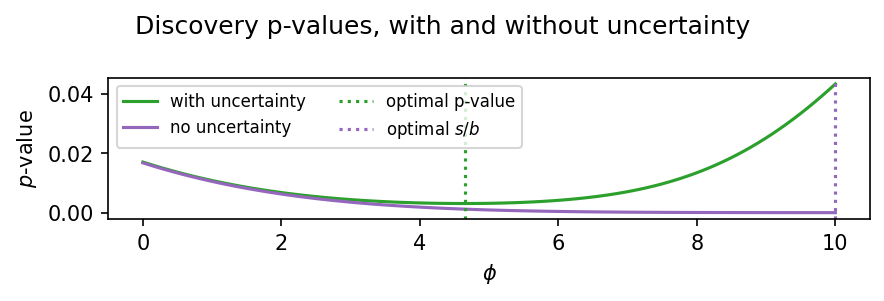

In [31]:
# fig, axs = plt.subplots(2, 1, sharex=True, figsize=[4,4])
fig, ax = plt.subplots()
axs = [ax]
axs[0].plot(phis, pvals, label="with uncertainty", color="C2")
axs[0].plot(phis, pvals_no_uncertainty, label="no uncertainty", color="C4")
axs[0].set_ylabel("$p$-value")
# plot vertical dotted line at minimum of p-values + s/b
best_phi = phis[jnp.argmin(pvals)]
axs[0].axvline(x=best_phi, linestyle="dotted", color="C2", label="optimal p-value")
axs[0].axvline(
    x=phis[jnp.argmin(pvals_no_uncertainty)],
    linestyle="dotted",
    color="C4",
    label=r"optimal $s/b$",
)
axs[0].legend(loc="upper left", ncol=2)
# s, b, db = ys
# s, b, db = s.ravel(), b.ravel(), db.ravel()  # everything is [[x]] for pyhf
# axs[1].fill_between(phis, s + b, b, color="C9", label="signal")
# axs[1].fill_between(phis, b, color="C1", label="background")
# axs[1].fill_between(phis, b - db, b + db, facecolor="k", alpha=0.2, label=r"$\sigma_b$")
axs[0].set_xlabel("$\phi$")
# axs[1].set_ylabel("yield")
# axs[1].legend(loc="lower left")
plt.suptitle("Discovery p-values, with and without uncertainty")
plt.tight_layout()

We see that the different $p$-values significantly diverge as we increase the uncertainty of the background yield. Moreover, the $p$-value without incorporating uncertainty -- which would be the targeted objective if we used Asimov stat-only significance -- has a minimum value at $\phi = 10$ that totally disregards the high uncertainty induced within the model.

However, we can rescue this analysis if we make sure we include the uncertainty in the objective we optimize. Using gradient descent, we can optimise this analysis in an uncertainty-aware way by directly optimising $\phi$ for the lowest discovery $p$-value. Here's how you do that:

In [38]:
import time

# The fast way!
# let's use the OptaxSolver wrapper from jaxopt to perform the minimisation
# set a couple of tolerance kwargs to make sure we don't stop too early
solver = OptaxSolver(pipeline, opt=optax.adam(1e-3), tol=1e-8, maxiter=10000)
pars = 9.0  # random init

start = time.perf_counter()
result = solver.run(pars).params
end = time.perf_counter()

print(
    f"our solution: phi={result:.5f}\ntrue optimum: phi={phis[jnp.argmin(pvals)]:.5f}\nbest s/b:     phi=10"
)
print(f"minimization took {end-start:.3f}s")

our solution: phi=4.63643
true optimum: phi=4.64646
best s/b:     phi=10
minimization took 1.989s


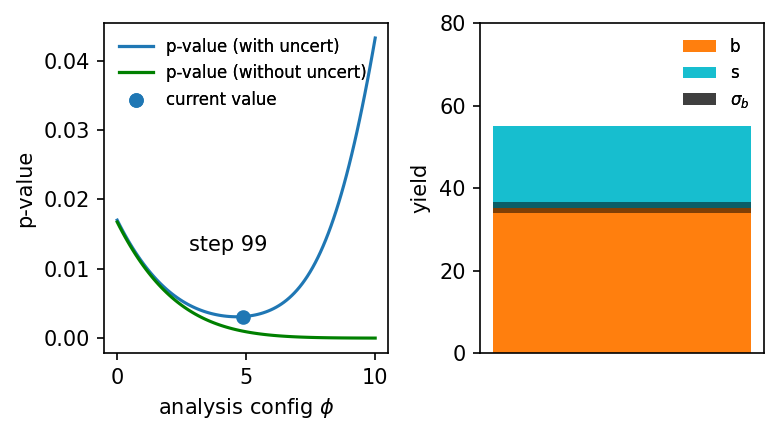

In [35]:
# The longer way (but with plots) -- takes a minute or two to run!
pipe = partial(pipeline, return_yields=True, uncertainty=True)
solver = OptaxSolver(pipe, opt=optax.adam(1e-1), has_aux=True)
pars = 9.0
state = solver.init_state(pars)  # we're doing init, update steps instead of .run()

fig, axs = plt.subplots(1, 2, figsize=[5.3, 3])
cam = Camera(fig)
steps = 10  # increase me for better results! (100ish works well)
for i in range(steps):
    pars, state = solver.update(pars, state)
    s, b, db = state.aux
    val = state.value
    ax = axs[0]
    cv = ax.plot(phis, pvals, c="C0")
    cvs = ax.plot(phis, pvals_no_uncertainty, c="green")
    current = ax.scatter(pars, val, c="C0")
    ax.set_xlabel(r"analysis config $\phi$")
    ax.set_ylabel("p-value")
    ax.legend(
        [
            mlines.Line2D([], [], color="C0"),
            mlines.Line2D([], [], color="green"),
            current,
        ],
        ["p-value (with uncert)", "p-value (without uncert)", "current value"],
        frameon=False,
    )
    ax.text(0.3, 0.31, f"step {i}", transform=ax.transAxes)
    ax = axs[1]
    ax.set_ylim((0, 80))
    b1 = ax.bar(0.5, b, facecolor="C1", label="b")
    b2 = ax.bar(0.5, s, bottom=b, facecolor="C9", label="s")
    b3 = ax.bar(
        0.5, db, bottom=b - db / 2, facecolor="k", alpha=0.5, label=r"$\sigma_b$"
    )
    ax.set_ylabel("yield")
    ax.set_xticks([])
    ax.legend([b1, b2, b3], ["b", "s", r"$\sigma_b$"], frameon=False)
    plt.tight_layout()
    cam.snap()

ani = cam.animate()
from IPython.display import HTML

HTML(ani.to_html5_video())